# img2seg - segment laminb tagged channels

Take the individual frames that we've extracted from the movie in `mov2img` and run the [Cellpose](http://cellpose.org) nuclear segmeter over them. Output one levelset frame per fluorescent channel. That means we'll be manually encoding the brightfield channels to avoid providing predictions for them. 

First we'll load the relevant packages and configuration.

In [1]:
from pathlib import Path
import types

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import cloudpickle
import tqdm
import cellpose
import cellpose.models
import mxnet as mx

from workflow_colony_formation import utils

In [2]:
config = utils.load_step_config('img2seg', ['mov2img', ])
    
# Find (and create if necessary) input and output dirs
root_dir = Path('../../..').resolve()
relative_local_staging = config.step_local_staging_dir
absolute_local_staging = root_dir / relative_local_staging
img_output_dir = 'seg'
(absolute_local_staging/img_output_dir).mkdir(parents=True, exist_ok=True)

Now we need to get a handle on the images we want to read in and segment. Let's take a look at the manifest of the parent step.

In [3]:
parent_manifest = pd.read_csv(absolute_local_staging / "../mov2img/manifest.csv")
parent_manifest.head(3)

,filepath,original_czi,channel,fluorophore,time,region
0,local_staging/mov2img/img/20170711_I01_001_M0_...,20170711_I01_001.czi,0,EGFP,0,0
1,local_staging/mov2img/img/20170711_I01_001_M0_...,20170711_I01_001.czi,0,EGFP,1,0
2,local_staging/mov2img/img/20170711_I01_001_M0_...,20170711_I01_001.czi,0,EGFP,2,0


And plot a channel at a few timesteps...

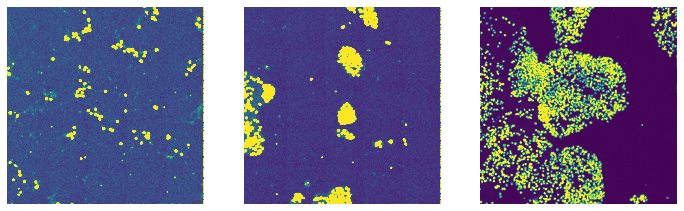

In [4]:
sample = parent_manifest[(parent_manifest.channel==0) & (parent_manifest.region==0)]
times = sample.time.unique()
times = times[0], times[len(times)//2], times[-1]
sample_fns = sample[sample.time.isin(times)].filepath

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for ax, fn in zip(axs, sample_fns):
    img = plt.imread(root_dir / fn)
    ax.imshow(img, vmax=np.percentile(img, 90))
    ax.axis('off')

Now we'll build a list of those we are going to segment. We're only going to be looking at the fluorescently tagged channels. 

In [5]:
filtered_manifest = parent_manifest[parent_manifest.fluorophore.isin(('EGFP', 'TaRFP'))]

Ok, we've gotten rid of the brightfield channels. Now we will apply cellpose to a sample image. If the cellpose models aren't available on your system (they are large and updated and so not pip installed) they will be automatically downloaded here. 

In [6]:
# Set up model, once as it is somewhat expensive
model = cellpose.models.Cellpose(mx.cpu(), model_type='nuclei')

def read_img(fn): 
    img = plt.imread(root_dir / fn)
    img = [np.expand_dims(img, -1), ] # Cellpose expects lists
    return img
    
def process_img(fn):
    img = read_img(fn)
    masks, flows, styles, diams = model.eval(img, [0,0])
    return masks[0], flows[0], styles[0], diams[0]

>>>> using CPU


In [7]:
sample_fn = filtered_manifest.filepath[0]
mask, flow, style, diam = process_img(sample_fn)

processing 1 images


What are all the returns? We just want a levelset segmentation right? Sure, that is what `masks` is but you also get a represenation of the flow field within the cell. This is a spatial gradient that points towards the center of the cell, compensating for corners and non-convexity. We can plot this with an a orientation-to-color map as shown in the CellPose logo shown below. Further infomation on hor to interpret this is available in the [CellPose repo](https://github.com/mouseland/cellpose) and in the accompanying [preprint](https://www.biorxiv.org/content/10.1101/2020.02.02.931238v1).

![logo](https://github.com/MouseLand/cellpose/blob/master/cellpose/logo/logo.png?raw=true)

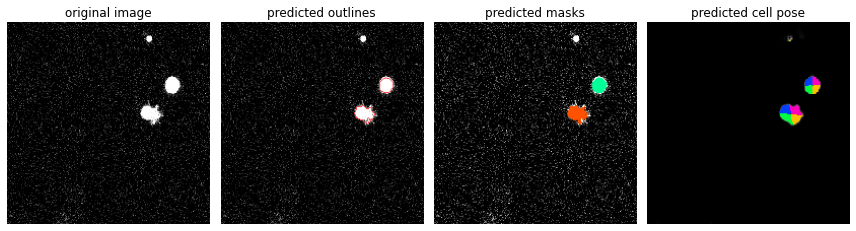

In [8]:
from cellpose import plot
fig = plt.figure(figsize=(12,5))
zoom = (slice(-200, -1), slice(0, 200))
plot.show_segmentation(fig, read_img(sample_fn)[0][zoom], mask[zoom], flow[0][zoom])
plt.tight_layout()
plt.show()

For these round nuclei there isn't much convexity to the exterior-to-centroid path.

From here on out, we'll keep just the levelset masks when we save the output. Now we'll set up our pipeline and apply it to the input images from the prior step's manifest.  

We need to save the output segmentations as tifs to allow the bitdepth necessary for level sets in the later frames.

In [9]:
def write_mask(mask, params):
    """Write mask to png with standard name format"""
    base_name = Path(params['filepath']).stem + ".tif"
    out_name = Path(img_output_dir) /  base_name
    skimage.io.imsave(absolute_local_staging / out_name, img, check_contrast=False)
    return relative_local_staging / out_name
    
def img_pipeline(params):
    mask, flow, style, diam =  process_img(params['filepath'])
    filepath = write_mask(mask, params)
    params.update(dict(filepath = str(filepath)))
    return params

n_params = 2 if config.interactive else len(filtered_manifest)
param_sets = []
for row_i in range(n_params):
    param_sets.append(dict(filtered_manifest.iloc[row_i]))

Apply serially. Multiprocessing doesn't help here because the application is already multithreaded through the mx library. 

This next one is the time-hog of the process.

In [10]:
manifests = []
for param_set in tqdm.tqdm(param_sets, "Segmenting"):
    manifests.append(img_pipeline(param_set))

config.manifest = pd.DataFrame(manifests)
config.metadata_columns = ['original_czi', 'channel', 'fluorophore', 'time', 'region', ]

Segmenting:   0%|          | 0/2 [00:00<?, ?it/s]

processing 1 images


Segmenting:  50%|█████     | 1/2 [00:39<00:39, 39.29s/it]

processing 1 images


Segmenting: 100%|██████████| 2/2 [01:20<00:00, 40.30s/it]


This should be all the segmentations written out:

In [11]:
config.manifest

,filepath,original_czi,channel,fluorophore,time,region
0,local_staging/img2seg/seg/20170711_I01_001_M0_...,20170711_I01_001.czi,0,EGFP,0,0
1,local_staging/img2seg/seg/20170711_I01_001_M0_...,20170711_I01_001.czi,0,EGFP,1,0


And finally, if this was called from a step, write the configuration back out. 

In [12]:
utils.dump_step_config(config)